# Hybrid Classifier with PyTorch

We build a hybrid classical-quantum neural network that classifies 2D points into two classes.
The classical NN feeds into a quantum circuit, whose expectation value is used for classification.

- Classify 2D points into two classes
- Hybrid classical-quantum classifier (classical NN + quantum circuit layer)
- PennyLane’s PyTorch interface
- Trained end-to-end with gradient backprop

In [1]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import itertools
import random


# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

## Generate Simple 2D Dataset

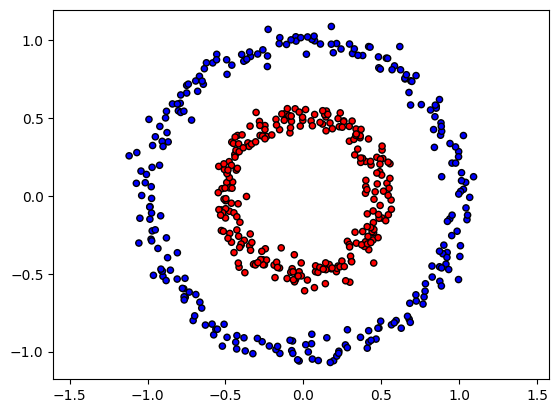

In [2]:
X, Y = make_circles(n_samples=500, noise=0.05, factor=0.5, random_state=0)

plt.scatter(X[:,0], X[:,1], c=Y, cmap='bwr', edgecolor='k', s=20)
plt.axis('equal')
plt.show()

## Prepare Data for PyTorch

Train/test split and convert to PyTorch tensors.

In [3]:
want_gpu = True
use_gpu = want_gpu and torch.cuda.is_available()
if use_gpu:
    print("Using GPU for training")
    device = torch.device("cuda")
else:
    print("Using CPU for training")
    device = torch.device("cpu")

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train_torch = torch.tensor(Y_train, dtype=torch.float32).to(device).view(-1,1)

X_val_torch = torch.tensor(X_val, dtype=torch.float32).to(device)
Y_val_torch = torch.tensor(Y_val, dtype=torch.float32).to(device).view(-1,1)


Using GPU for training


## Define Quantum Circuit

We will use a PennyLane device and a parametrized quantum circuit.

- n qubits (for binary classification)
- Angle embedding of inputs
- Simple variational ansatz

In [4]:
def make_quantum_layer(n_qubits, n_layers):
    # lightning.gpu works only with GPUs with certain capabilities.
    try:
        dev = qml.device("lightning.gpu" if use_gpu else "default.qubit", wires=n_qubits)
    except ValueError:
        dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev, interface="torch")
    def quantum_circuit(inputs, weights):
        # The classical inputs become angles in quantum rotation gates.
        qml.AngleEmbedding(inputs, wires=list(range(n_qubits)))

        # Apply a series of Strongly Entangling Layers
        qml.StronglyEntanglingLayers(weights, wires=list(range(n_qubits)))

        # Measure the expectation values of PauliZ for each qubit
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

    # Create a TorchLayer that wraps the quantum circuit
    weight_shapes = {"weights": (n_layers, n_qubits, 3)}  # Each qubit has 3 rotation parameters per layer
    qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
    return qlayer


where the weights are the parameters of the circuit, representing $\phi$, $\theta$, and $\omega$ angles for each rotation gates.

## Define Hybrid Model

We’ll use:

- Classical Layer (PyTorch NN), which is deliverately simple/linear
- Quantum Layer (PennyLane Circuit)
- Final Sigmoid for Binary classification

In [5]:
class HybridClassifier(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super().__init__()
        self.classical = nn.Linear(2, n_qubits)  # Weak, linear mapping
        self.quantum = make_quantum_layer(n_qubits, n_layers)
        self.post_quantum = nn.Linear(n_qubits, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.classical(x)
        x = self.quantum(x)
        x = self.post_quantum(x)
        x = self.sigmoid(x)
        return x

## Train Model with Grid Search

In [6]:
def train_model(
    model: nn.Module,
    X_train: torch.Tensor,
    Y_train: torch.Tensor,
    lr: float,
    n_epochs: int,
):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()
    losses = []
    for _ in range(n_epochs):
        optimizer.zero_grad()
        output = model(X_train)
        loss = loss_fn(output, Y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    return losses


def evaluate_model(
    model: nn.Module,
    X_val: torch.Tensor,
    Y_val: torch.Tensor,
):
    model.eval()
    with torch.no_grad():
        output = model(X_val)
        loss = nn.BCELoss()(output, Y_val)
    return loss.item()

In [7]:
from sympy import hyper


hyperparams = dict(
    n_qubits = [2, 4],
    n_layers = [2, 3],
    learning_rate = [0.05, 0.01],
)
n_epochs = 300

best_val_loss = float('inf')
best_config = None
results = []

for comboination in itertools.product(*hyperparams.values()):
    # Create a configuration dictionary from the hyperparameters
    config = dict(zip(hyperparams.keys(), comboination))
    print(config, end=' ')

    n_qubits = config['n_qubits']
    n_layers = config['n_layers']
    lr = config['learning_rate']

    # Create and train the model
    model = HybridClassifier(n_qubits, n_layers).to(device)
    train_model(model, X_train_torch, Y_train_torch, lr, n_epochs)

    # Evaluate on validation set
    val_loss = evaluate_model(model, X_val_torch, Y_val_torch)
    results.append((n_layers, lr, val_loss))

    print(f"Validation Loss={val_loss:6.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_config = config

print("\nBest Config:")
print(best_config)
print(f"best_val_loss={best_val_loss:6.4f}")


{'n_qubits': 2, 'n_layers': 2, 'learning_rate': 0.05} Validation Loss=0.0253
{'n_qubits': 2, 'n_layers': 2, 'learning_rate': 0.01} Validation Loss=0.1545
{'n_qubits': 2, 'n_layers': 3, 'learning_rate': 0.05} Validation Loss=0.0165
{'n_qubits': 2, 'n_layers': 3, 'learning_rate': 0.01} Validation Loss=0.1054
{'n_qubits': 4, 'n_layers': 2, 'learning_rate': 0.05} Validation Loss=0.0049
{'n_qubits': 4, 'n_layers': 2, 'learning_rate': 0.01} Validation Loss=0.1171
{'n_qubits': 4, 'n_layers': 3, 'learning_rate': 0.05} Validation Loss=0.0085
{'n_qubits': 4, 'n_layers': 3, 'learning_rate': 0.01} Validation Loss=0.0773

Best Config:
{'n_qubits': 4, 'n_layers': 2, 'learning_rate': 0.05}
best_val_loss=0.0049


## Retrain Best Model on Full Dataset

In [8]:
# Convert the full dataset to PyTorch tensors
X_full_torch = torch.tensor(X, dtype=torch.float32).to(device)
Y_full_torch = torch.tensor(Y, dtype=torch.float32).to(device).view(-1,1)

# Use the best configuration to create the final model
n_qubits = best_config['n_qubits']
n_layers = best_config['n_layers']
lr = best_config['learning_rate']

# Create the final model with the best configuration
final_model = HybridClassifier(n_qubits, n_layers)
final_model.to(device)

# Train the final model on the full dataset
losses = train_model(final_model, X_full_torch, Y_full_torch, lr, n_epochs=500)

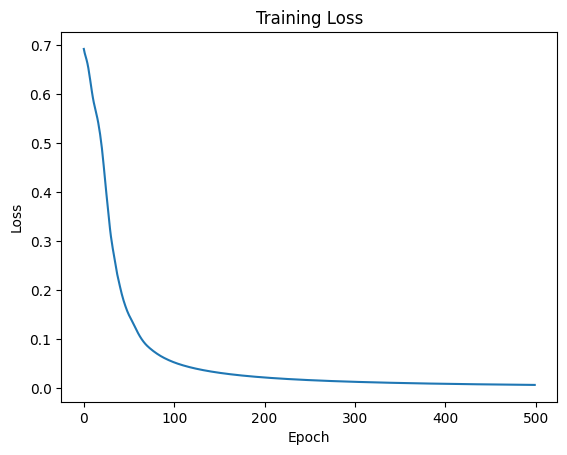

In [9]:
# Plot the training loss
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Visualize Decision Boundary

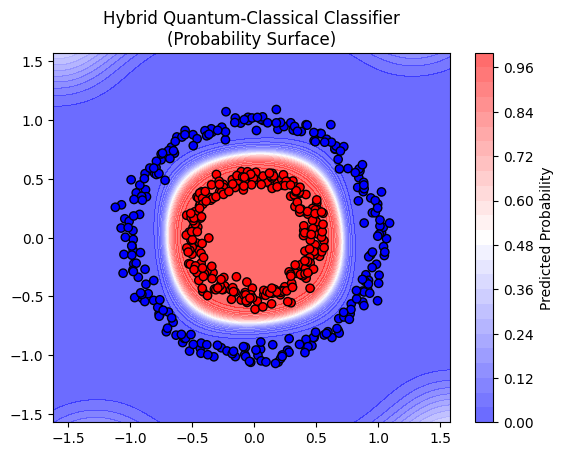

In [10]:
def plot_decision_boundary_with_probs(model, X, y):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32).to(device)
    grid_tensor.to(device)

    with torch.no_grad():
        probs = model(grid_tensor).cpu().numpy().reshape(xx.shape)

    # Use continuous probability for color
    contour = plt.contourf(xx, yy, probs, levels=30, cmap='bwr', alpha=0.6)
    plt.colorbar(contour, label='Predicted Probability')

    # Scatter actual training points
    plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', edgecolors='k')
    plt.title('Hybrid Quantum-Classical Classifier\n(Probability Surface)')


final_model.eval()
plot_decision_boundary_with_probs(final_model, X, Y)